# Multi-class classification 300 bird species dataset

This notebook implements transfer learning to classify bird species.

Dataset used is "300 Bird Species - Classification" by Gerry from Kaggle:
https://www.kaggle.com/gpiosenka/100-bird-species

# Load, inspect and prepare data



In [2]:
#install kaggle
!pip install kaggle

In [3]:
# Create directory for the dataset
!mkdir /content/300_bird_species
dataset_dir = "/content/300_bird_species"

In [4]:
# Configure the path to "kaggle.json"
import os
os.environ['KAGGLE_CONFIG_DIR'] = dataset_dir
!chmod 600 /content/300_bird_species/kaggle.json

In [5]:
# Download data
!kaggle datasets download -d gpiosenka/100-bird-species

 99% 1.06G/1.08G [00:10<00:00, 112MB/s]
100% 1.08G/1.08G [00:10<00:00, 108MB/s]


In [6]:
# Unzip data
import zipfile

zip = zipfile.ZipFile("/content/100-bird-species.zip")
zip.extractall(dataset_dir)

In [15]:
# Define train and test directories
train_dir = dataset_dir + "/" + "train"
test_dir = dataset_dir + "/" + "test"
valid_dir = dataset_dir + "/" + "valid"

train_dir, test_dir, valid_dir

('/content/300_bird_species/train',
 '/content/300_bird_species/test',
 '/content/300_bird_species/valid')

In [20]:
# load data using tensorflow ImageDataGenerator class
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator instance
data_generator = ImageDataGenerator(rescale = 1/255.) # normalize images so their values are between 0 and 1

IMG_SIZE = (224, 224) # all images in 300 Bird Species dataset have size of 224x224

# Load train and test images from directories
train_dataset = data_generator.flow_from_directory(train_dir,
                                                  target_size = IMG_SIZE
                                                  )
test_dataset = data_generator.flow_from_directory(test_dir,
                                                  target_size = IMG_SIZE
                                                  )
valid_dataset = data_generator.flow_from_directory(valid_dir,
                                                  target_size = IMG_SIZE
                                                  )


Found 43622 images belonging to 300 classes.
Found 1500 images belonging to 300 classes.
Found 1500 images belonging to 300 classes.


In [22]:
# Get class names
class_names = train_dataset.class_indices
class_names = list(class_names.keys())

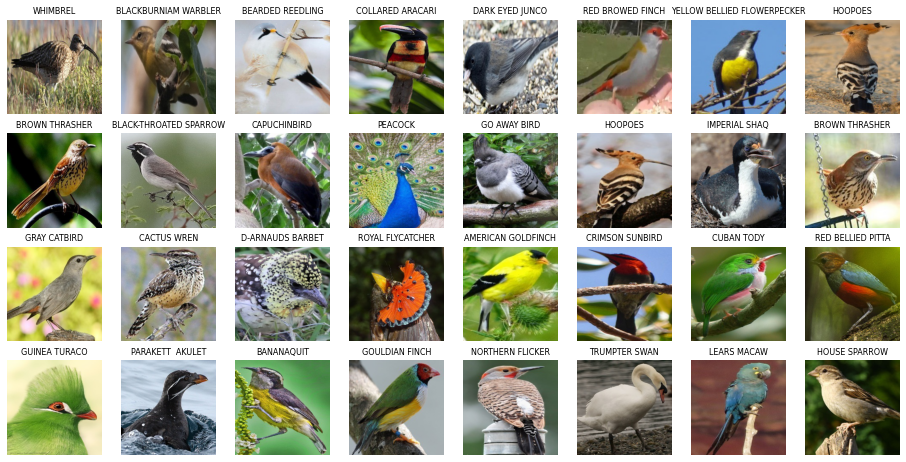

In [23]:
# View some samples from dataset
import matplotlib.pyplot as plt

# get single batch from dataset
data_one_batch = train_dataset.next()  
images_one_batch = data_one_batch[0]      
# labels are one-hot encoded, so we take argmax to get numerical representation
classes_one_batch = tf.argmax(data_one_batch[1], axis = 1)  


plt.figure(figsize = (16,8))
for n, image in enumerate(images_one_batch):
  plt.subplot(4, 8, n+1)
  plt.imshow(image)
  plt.title(class_names[classes_one_batch[n]], fontdict = {'fontsize' : 8})
  plt.axis("off")

#Transfer learning using EffecientNetB0

Creating and training model using EfficientNetB0 baseline from Tensorflow Hub

In [19]:
import tensorflow_hub as hub

baseline = hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
           trainable=False) # we're not training baseline model's layers to prevent overfitting

In [25]:
# create the model using sequential API
model = tf.keras.Sequential([
      baseline,
      tf.keras.layers.Dense(len(class_names), activation = "softmax")
])

# compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["accuracy"])

# fit the model
history_0 = model.fit(train_dataset,
                      epochs = 100,
                      validation_data = valid_dataset,
                      callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience = 1, verbose = 1),
                                   tf.keras.callbacks.EarlyStopping(restore_best_weights = True,
                                                                    patience = 2, verbose = 1)])  

Epoch 1/100
1364/1364 [==============================] - 173s 124ms/step - loss: 0.9712 - accuracy: 0.8513 - val_loss: 0.1603 - val_accuracy: 0.9733
Epoch 2/100
1364/1364 [==============================] - 169s 124ms/step - loss: 0.1923 - accuracy: 0.9641 - val_loss: 0.1050 - val_accuracy: 0.9787
Epoch 3/100
1364/1364 [==============================] - 169s 124ms/step - loss: 0.1097 - accuracy: 0.9804 - val_loss: 0.0802 - val_accuracy: 0.9840
Epoch 4/100
1364/1364 [==============================] - 167s 123ms/step - loss: 0.0713 - accuracy: 0.9877 - val_loss: 0.0711 - val_accuracy: 0.9813
Epoch 5/100
1364/1364 [==============================] - 167s 122ms/step - loss: 0.0486 - accuracy: 0.9916 - val_loss: 0.0643 - val_accuracy: 0.9793
Epoch 6/100
1364/1364 [==============================] - 167s 122ms/step - loss: 0.0338 - accuracy: 0.9943 - val_loss: 0.0582 - val_accuracy: 0.9833
Epoch 7/100
1364/1364 [==============================] - 168s 123ms/step - loss: 0.0247 - accuracy: 0.9956

In [28]:
# evaluate model on test data
model.evaluate(test_dataset)

47/47 [==============================] - 6s 121ms/step - loss: 0.0299 - accuracy: 0.9940


[0.029866812750697136, 0.9940000176429749]

# Analyze model predictions on test data

In [29]:
# save model
model.save("300_bird_species_EFFNetB0.h5")

In [50]:
# get model predictions and true labels
import numpy as np

images = []
true_labels = []
predictions = []

for n in range(len(test_dataset)):
  image_batch, label_batch = test_dataset.next()
  images.append(image_batch)
  true_labels.append(tf.argmax(label_batch, axis = 1))
  predictions.append(tf.argmax(model.predict(image_batch), axis = 1))

images = np.concatenate(images)
true_labels = np.concatenate(true_labels)
predictions = np.concatenate(predictions)

In [52]:
# get wrong predictions
mask = true_labels != predictions
images = images[mask]
true_labels = true_labels[mask]
predictions = predictions[mask]

len(images), len(true_labels), len(predictions)

(9, 9, 9)

Out of 1500 predictions, only 9 were wrong, Let's visualize them

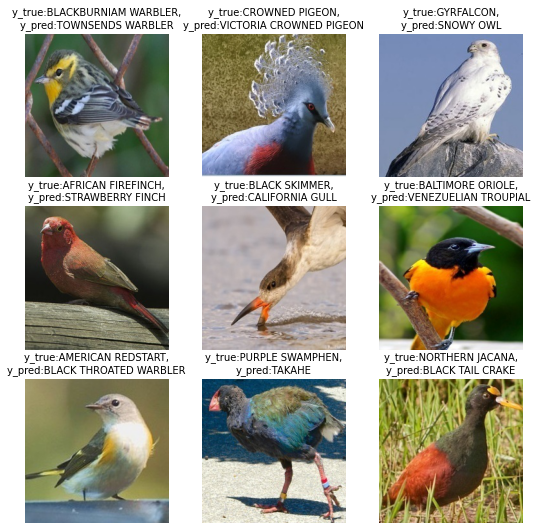

In [59]:
# visualize wrong predictions

plt.figure(figsize =  (9,9))
for n, image in enumerate(images):
  plt.subplot(3, 3, n+1)
  plt.imshow(image)
  plt.title(f"y_true:{class_names[true_labels[n]]},\ny_pred:{class_names[predictions[n]]}", fontdict = {"fontsize" : 10})
  plt.axis('off')